## Tabular TD learning
While the TD rules included in this notebook were designed to be used to train value function approximated by a neural network (in nengo), they can be used in other contexts. Here we use LMUs for simple tabular RL. These examples are meant to be very simple demonstrations of how you might use the LMU class defined in lmu_networks.py and the get_critic_transforms function in online_rl_networks to build custom training loops using LMUs

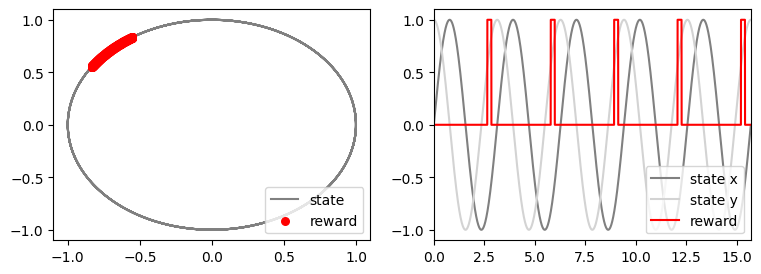

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

## Very simple RL problem for testing: Go around a circle and get reward at particular spots
# The state is (x,y) position 
T=np.pi*5
dt = 0.001
timesteps = np.arange(0,T,dt)

def state_fun(t):
    return np.stack([np.sin(t*2), np.cos(t*2)]).T
sim_path = state_fun(timesteps)

def reward_fun(t):
    if isinstance(t, np.ndarray):
        rewards = np.zeros(len(t))
        rewards[np.sqrt(np.sum((state_fun(t) - np.array([-0.707,0.707]))**2,axis=1)) < 0.2] = 1.
    else:
        rewards = 1. if (np.sqrt(np.sum((state_fun(t) - np.array([-0.707,0.707]))**2)) < 0.2) else 0.
    return rewards

rewards = reward_fun(timesteps)

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(sim_path[:,0],sim_path[:,1], label='state',zorder=1,color='grey')
plt.scatter(sim_path[rewards>0,0], sim_path[rewards>0,1], label='reward',s=30,zorder=2, color='red')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')

## TD(0)

In [7]:
from online_rl_networks import get_critic_transforms
from lmu_networks import LMU

# Parameters
lr = 0.01
discount = 0.95
theta = 0.5
q_r = 8
q_v = 8

# get_critic_transforms returns that matrices we apply to the LMU states to obtain different TD errors
# Input:
#     algor: 'TD0', 'TDtheta', 'TD(lambda)', or 'TD(Lambda)' (the last currently only works when using neural populations)
#     discount: rate of discount in units of seconds
#     n_neurons_state: number of neurons if using a state population
#     q_a, q_r, q_v: dim of LMU memory state for activities, value estimates, and reward signal
# Output:
#     activity_lmu_transform: matrix applied to m_a, LMU memory for activities
#     reward_lmu_transform: matrix applied to m_r, LMU memory for reward
#     value_transform: matrix applied to V, the current value output
#     value_lmu_transform: matrix applied to m_v, LMU memory for value
# The TD error at time t will be 
#     reward_lmu_transform @ m_r(t) + value_transform @ V(t) - value_lmu_transform @ m_v(t)
# m_a(t) is needed when using neural populations and the PES rule
_, reward_lmu_transform, value_transform, value_lmu_transform = get_critic_transforms('TDtheta', discount, 1, theta,
                                                     q_a=1, q_r = q_r, q_v=q_v) # not using activities so set n_neurons=1, q_a = 1

# Initialize LMUs
lmu_r = LMU(theta, q_r, dt, size_in=1) 
lmu_v = LMU(theta, q_v, dt, size_in=1)

n_period = int(np.pi/dt)
values = np.zeros(n_period)
for t in timesteps[int(theta/dt):]:
    # Input from env 
    #(normally we'd have a function that takes action input, but we have a fixed action schedule in this example)
    state = state_fun(t)
    reward = reward_fun(t)
     
    # Current index for value table (to get the current value)
    i = int(n_period*(t %np.pi)/np.pi)

    # Past index for value table (to get the past value that gets updated)
    j = i - int(theta/dt)
    
    # Current value estimate for this state
    value = values[i]

    # Update LMUs
    lmu_v.step(value)
    lmu_r.step(reward)

    # TD error from LMUs
    td =  reward_lmu_transform @ lmu_r.state + value_transform * value - value_lmu_transform @ lmu_v.state

    # Update
    values[j] += lr*td.item()

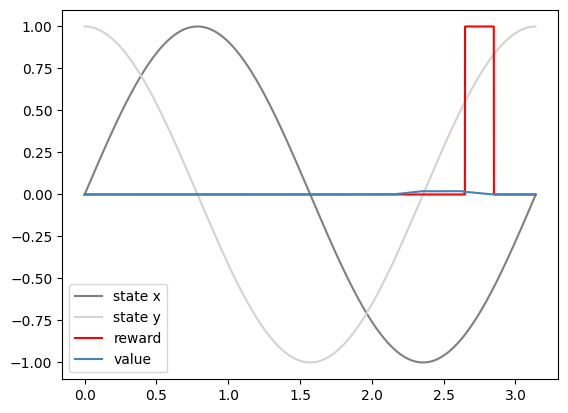

In [8]:
plt.figure()
plt.plot(timesteps[:n_period],sim_path[:n_period,0], label='state x',color='grey')
plt.plot(timesteps[:n_period],sim_path[:n_period,1], label='state y',color='lightgrey')
plt.plot(timesteps[:n_period],rewards[:n_period], label='reward', color='red')
plt.plot(timesteps[:n_period],values, label='value', color='steelblue')
plt.legend()

Text(0.5, 1.0, 'Zoom in')

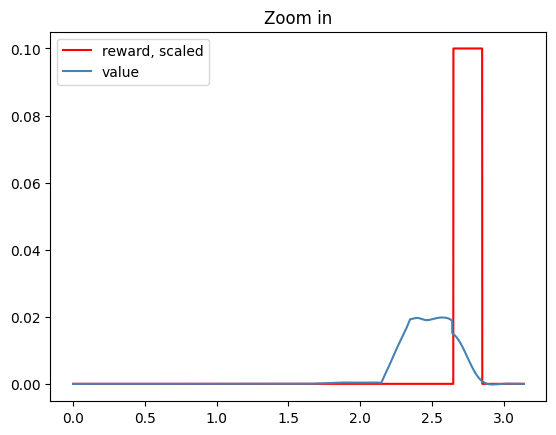

In [9]:
plt.figure()
plt.plot(timesteps[:n_period],0.1*rewards[:n_period], label='reward, scaled', color='red')
plt.plot(timesteps[:n_period],values, label='value', color='steelblue')
plt.legend()
plt.title('Zoom in')